In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.nn import Module, Conv2d, Linear, Dropout2d, NLLLoss, MaxPool2d, Flatten, Sequential, ReLU
from torch.optim import Adam, LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
algorithm_globals.random_seed = 42
qi = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Part 1: Simple Classification and Regression

## 1. Classification

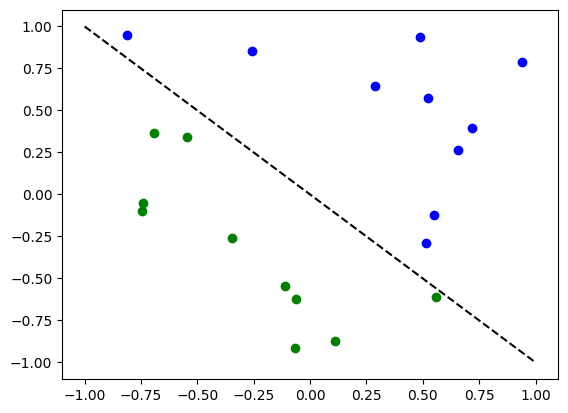

In [3]:
num_inputs = 2
num_samples = 20

X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)
y = 2 * y01 - 1

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1,1], [1,-1], "--", color="black")
plt.show()

### A. Classification with PyTorch and OpflowQNN

In [4]:
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)
print(qnn1.operator)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print(f"Initial weights: {initial_weights}")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_1: ┤1                                                         ├
  «     └──────────────────────────────────────────────────────────┘
  )
])
Initial weights: [-0.01256962  0.06653564  0.04005302 -0.03752667  0.06645196  0.06095287
 -0.02250432 -0.04233438]


In [5]:
model1(X_[0, :])

tensor([-0.3285], grad_fn=<_TorchNNFunctionBackward>)

In [6]:
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

model1.train()

def closure():
    optimizer.zero_grad()
    loss = f_loss(model1(X_), y_)
    loss.backward()
    print(loss.item())
    return loss

optimizer.step(closure)

25.535646438598633
22.696760177612305
20.039228439331055
19.68790626525879
19.267210006713867
19.025371551513672
18.154708862304688
17.33785629272461
19.082544326782227
17.07332420349121
16.21839141845703
14.992581367492676
14.929339408874512
14.914534568786621
14.907638549804688
14.902363777160645
14.902134895324707
14.90211009979248
14.902111053466797


tensor(25.5356, grad_fn=<MseLossBackward0>)

Accuracy: 0.8


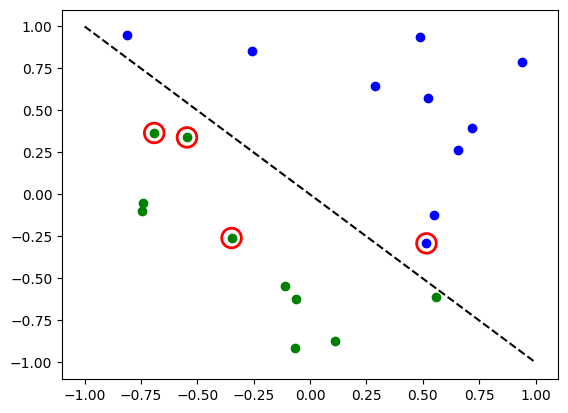

In [7]:
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print(f"Accuracy: {sum(y_predict == y)/len(y)}")

for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### B. Classification with PyTorch and CircuitQNN

In [8]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_qubits=num_inputs, entanglement="linear", reps=1)

qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: "{:b}".format(x).count("1") % 2
output_shape = 2
qnn2 = CircuitQNN(qc, 
                  input_params=feature_map.parameters,
                  weight_params=ansatz.parameters,
                  interpret=parity,
                  output_shape=output_shape,
                  quantum_instance=qi)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print(f"Initial weights: {initial_weights}")
model2 = TorchConnector(qnn2, initial_weights=initial_weights)

Initial weights: [ 0.0364991  -0.0720495  -0.06001836 -0.09852755]


In [9]:
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()

model2.train()

def closure():
    optimizer.zero_grad(set_to_none=True)
    loss = f_loss(model2(X_), y01_)
    loss.backward()
    
    print(loss.item())
    return loss

optimizer.step(closure)

0.6925069093704224
0.6881508231163025
0.6516684293746948
0.6485998034477234
0.6394745111465454
0.7055025100708008
0.6669358611106873
0.6768221259117126
0.6784337759017944
0.7485936284065247
0.6641563773155212
0.6561498045921326
0.66301429271698
0.6441987752914429
0.6511136293411255
0.6289191246032715
0.6247060298919678
0.6366127729415894
0.6195870041847229
0.6179186105728149


tensor(0.6925, grad_fn=<NllLossBackward0>)

## 2. Regression

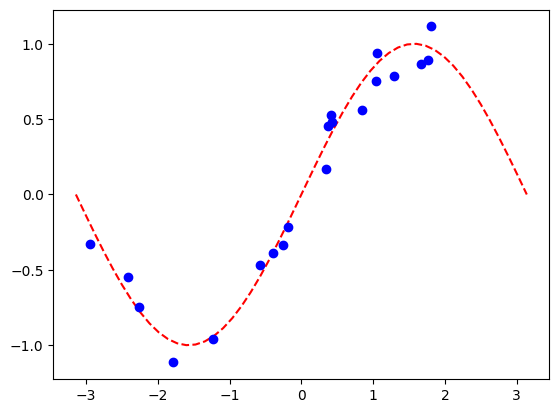

In [10]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

### A. Regression with PyTorch and OpflowQNN

In [11]:
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qnn3 = TwoLayerQNN(1, feature_map=feature_map, ansatz=ansatz, quantum_instance=qi)
print(qnn3.operator)

initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
model3 = TorchConnector(qnn3, initial_weights=initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
     ┌───────┐┌───────┐
  q: ┤ fm(x) ├┤ vf(y) ├
     └───────┘└───────┘
  )
])


In [12]:
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")

model3.train()

def closure():
    optimizer.zero_grad(set_to_none=True)
    loss = f_loss(model3(Tensor(X)), Tensor(y))
    loss.backward()
    print(loss.item())
    return loss

optimizer.step(closure)

14.947757720947266
2.948650360107422
8.952412605285645
0.37905153632164
0.24995625019073486
0.2483610212802887
0.24835753440856934


tensor(14.9478, grad_fn=<MseLossBackward0>)

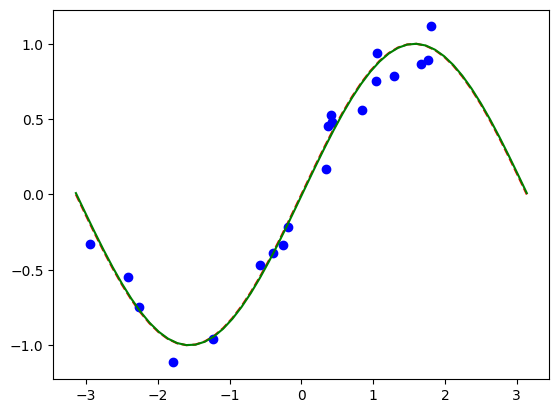

In [13]:
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")

y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

# Part 2: MNIST Classification, Hybrid QNNs

## Step 1: Defining Data-loaders for train and test

In [14]:
manual_seed(42)

batch_size = 1
n_samples = 100

X_train = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

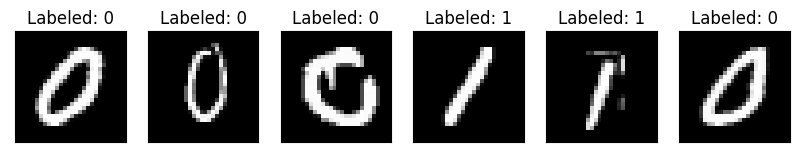

In [15]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10,3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    
    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title(f"Labeled: {targets[0].item()}")
    
    n_samples_show -= 1

In [16]:
n_samples = 50

X_test = datasets.MNIST(root="./data",
                        train=False,
                        download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

### Step 2: Defining the QNN and Hybrid Model

In [17]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qnn = TwoLayerQNN(2,
                      feature_map,
                      ansatz,
                      input_gradients=True,
                      exp_val=AerPauliExpectation(),
                      quantum_instance=qi
    )
    return qnn

qnn4 = create_qnn()
print(qnn4.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [20]:
class Net(Module):
    
    def __init__(self, qnn) -> None:
        super().__init__()
        self.conv1 = Conv2d(1,2, kernel_size=5)
        self.conv2 = Conv2d(2,16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x ,2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)
    
model4 = Net(qnn4)

In [21]:
# Define model, optimizer, and loss function
optimizer = Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.6836
Training [20%]	Loss: -1.0655
Training [30%]	Loss: -1.2955
Training [40%]	Loss: -1.5313
Training [50%]	Loss: -1.7526
Training [60%]	Loss: -1.9558
Training [70%]	Loss: -2.1181
Training [80%]	Loss: -2.5171
Training [90%]	Loss: -2.8504
Training [100%]	Loss: -3.1637


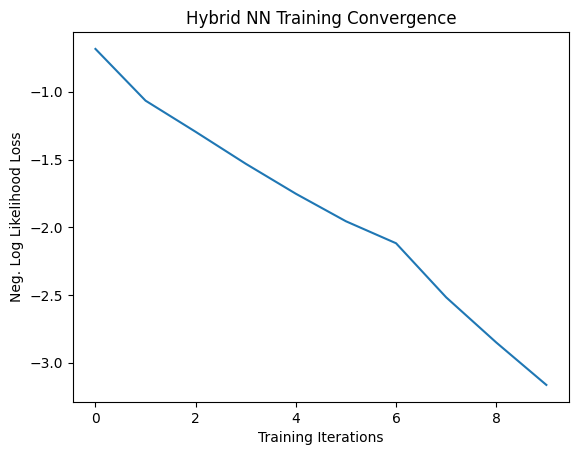

In [22]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [23]:
torch.save(model4.state_dict(), "model4.pt")

In [24]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [25]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.2449
	Accuracy: 100.0%


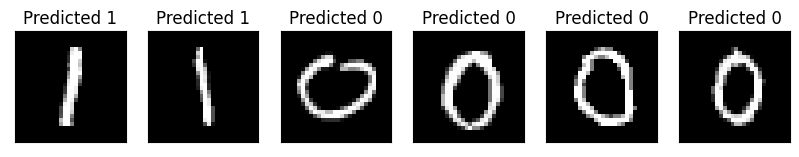

In [26]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1